In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import Data_Process as dp
from sklearn.model_selection import train_test_split
import Model_LSTM as mlstm

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import Constants





In [3]:
info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv").set_index("timestamp")

In [29]:
ctrain.shape

(24236806, 9)

In [4]:
DEBUG = Constants.DEBUG
EPOCHS = Constants.EPOCHS
N_ASSETS = Constants.N_ASSETS
WINDOW_SIZE = Constants.WINDOW_SIZE
BATCH_SIZE = Constants.BATCH_SIZE
PCT_VALIDATION = Constants.PCT_VALIDATION # last 10% of the data are used as validation set

In [5]:
#train mini data
#n_steps_to_train = 360*24*60 #1 year
n_steps_to_train = 10000000
ctrain_mini =  ctrain[-n_steps_to_train:]

In [6]:
ctrain_processed = dp.process_all_assets(ctrain_mini)



In [7]:
ctrain_processed.head()
#ctrain_processed[]


Asset_ID     Count      Open      High       Low     Close  \
timestamp                                                                
1588480860         3  0.000000  0.000000  0.000000  0.000000  0.000000   
1588480860         2  0.000000  0.000000  0.000000  0.000000  0.000000   
1588480860         0  0.000000  0.000000  0.000000  0.000000  0.000000   
1588480860         1  0.000000  0.000000  0.000000  0.000000  0.000000   
1588480860         4 -0.298876 -0.076916 -0.076845 -0.076961 -0.076917   

             Volume      VWAP  Target    Spread  Close_Open  Upper_Shadow  \
timestamp                                                                   
1588480860  0.00000  0.000000     0.0  0.000000         0.0      0.000000   
1588480860  0.00000  0.000000     0.0  0.000000         0.0      0.000000   
1588480860  0.00000  0.000000     0.0  0.000000         0.0      0.000000   
1588480860  0.00000  0.000000     0.0  0.000000         0.0      0.000000   
1588480860  3.41432 -0.076915     0.0 -0.065064         0.0     -0.061862   

            Lower_Shadow    spread  mean_trade  group_num  is_real  \
timestamp                                                            
1588480860      0.000000  0.000000    0.000000          0        0   
1588480860      0.000000  0.000000    0.000000          0        0   
1588480860      0.000000  0.000000    0.000000          0        0   
1588480860      0.000000  0.000000    0.000000          0        0   
1588480860     -0.065424 -0.065064   52.182255          0        1   

            asset_order  
timestamp                
1588480860            0  
1588480860            1  
1588480860            2  
1588480860            3  
1588480860            4

In [12]:
ctrain_processed[ctrain_processed.is_real==0].shape

(196816, 18)

In [8]:
#reshape for model

targets = ctrain_processed['Target'].to_numpy().reshape(-1, Constants.N_ASSETS)
features = ctrain_processed.columns.drop(['Asset_ID', 'Target', 'group_num','is_real'])
train = ctrain_processed[features]
train_data = train.values.reshape(-1, Constants.N_ASSETS, train.shape[-1])


train_data.shape

(728344, 14, 14)

In [9]:
X_train, X_test = train_data[:-len(train_data)//PCT_VALIDATION], train_data[-len(train_data)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train_data)//PCT_VALIDATION], targets[-len(train_data)//PCT_VALIDATION:]

In [10]:
train_generator = mlstm.sample_generator(X_train, y_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = mlstm.sample_generator(X_test, y_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 14, 14)
Target shape: (1024, 14)


In [19]:
model = mlstm.get_modell(X_train, y_train)
model.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 14, 14)] 0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, 15, 14)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_29 (Lambda)              (None, 15, 14)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_30 (Lambda)              (None, 15, 14)       0           input_3[0][0]                    
____________________________________________________________________________________________

In [20]:
tf.keras.utils.plot_model(mlstm.get_modell(X_train, y_train,n_assets=1), show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [21]:
history = model.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
641/641 [==============================] - 187s 236ms/step - loss: 0.0089 - Correlation: 0.0190 - val_loss: 0.0038 - val_Correlation: 0.0191

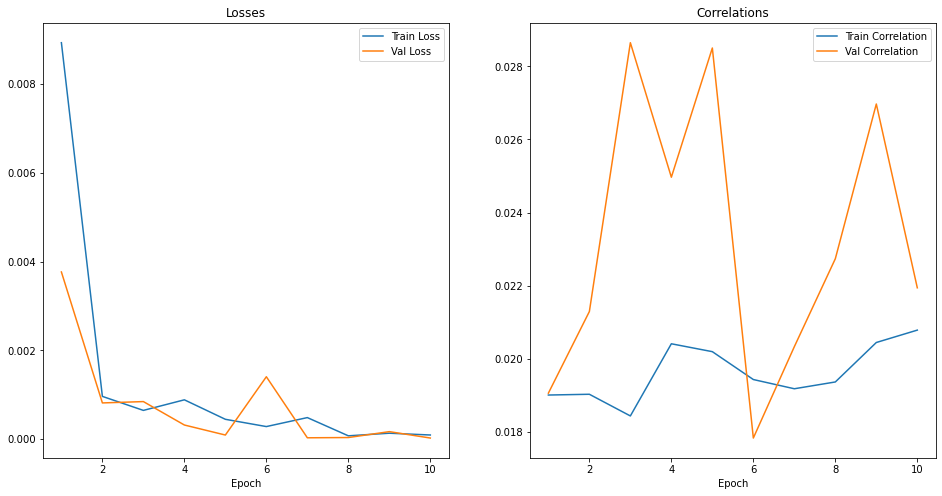

In [22]:
mlstm.plot_training_history(history)

In [23]:
predictions = model.predict(val_generator)

Asset:    Corr. coef.
---------------------
Cardano: 0.0054


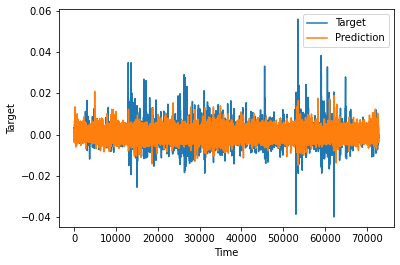

Bitcoin Cash: 0.0034


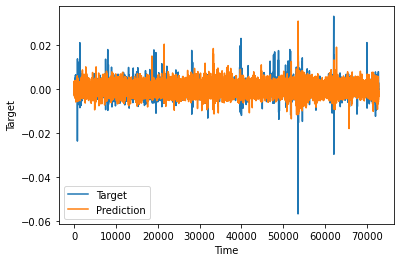

Binance Coin: 0.0004


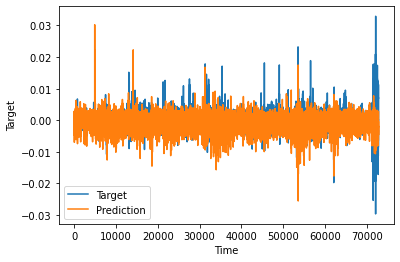

Bitcoin: 0.0618


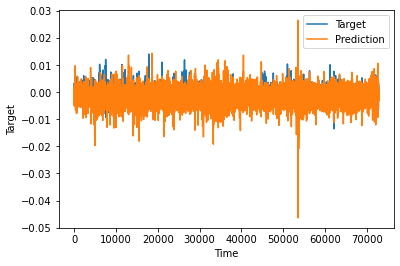

Dogecoin: 0.0095


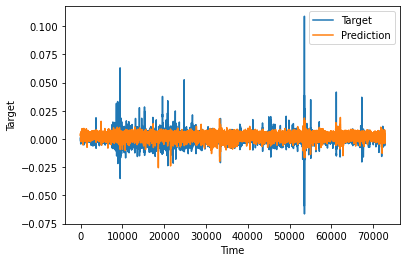

EOS.IO: -0.0086


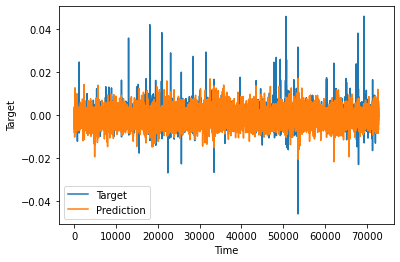

Ethereum Classic: 0.0124


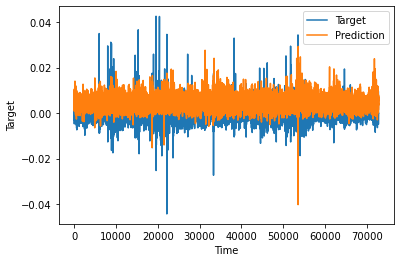

Ethereum: 0.0084


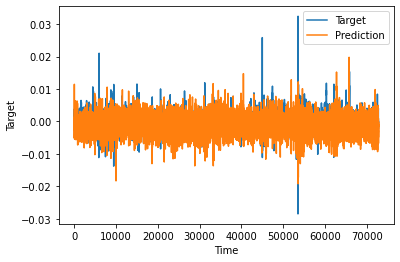

IOTA: 0.0046


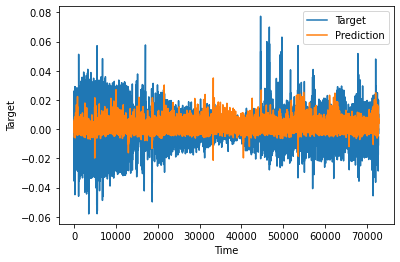

Litecoin: -0.0046


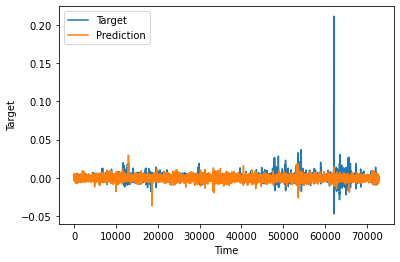

Maker: -0.0214


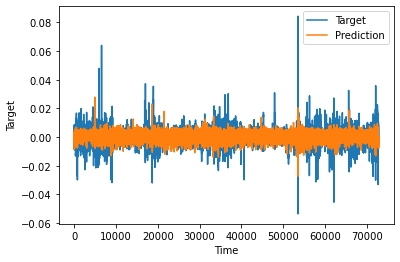

TRON: -0.0036


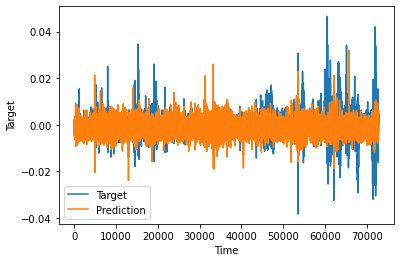

Stellar: 0.0048


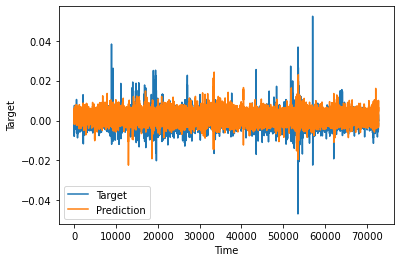

Monero: 0.0206


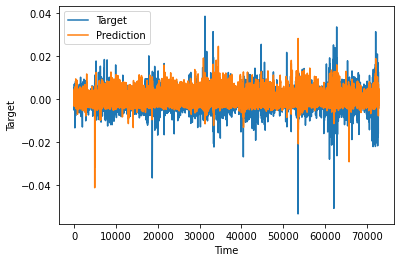

In [24]:
perf_df = mlstm.prediction_details(predictions=predictions, y_test=y_test, asset_details=info, model_name='1 layer LSTM',assets=range(N_ASSETS))


perf_df = perf_df.append([pd.Series(['1 layer LSTM', 'WEIGhTED', (perf_df['corr']*perf_df['weights']).sum(), 1 ],index = perf_df.columns)], ignore_index=True)
perf_df.to_csv('Performance1layerLSTM.csv')

In [ ]:
perf_df

Multivariate 2-Layered Bidirectional LSTM

In [25]:
model_Bidirectional_2_layer = mlstm.get_model_Bidirectional_2_layer(X_train, y_train)
model_Bidirectional_2_layer.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15, 14, 14)] 0                                            
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 15, 14)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_44 (Lambda)              (None, 15, 14)       0           input_5[0][0]                    
__________________________________________________________________________________________________
lambda_45 (Lambda)              (None, 15, 14)       0           input_5[0][0]                    
____________________________________________________________________________________________

In [26]:
history_Bidirectional_2_layer = model_Bidirectional_2_layer.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])



Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
641/641 [==============================] - 517s 628ms/step - loss: 0.0052 - Correlation: 0.0176 - val_loss: 0.0018 - val_Correlation: 0.0179

In [27]:
predictions_Bidirectional_2_layer = model_Bidirectional_2_layer.predict(val_generator)

Asset:    Corr. coef.
---------------------
Cardano: -0.0000


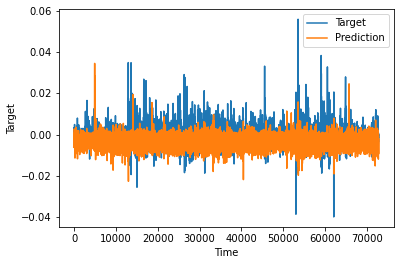

Bitcoin Cash: -0.0045


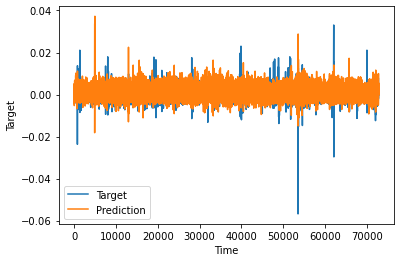

Binance Coin: 0.0120


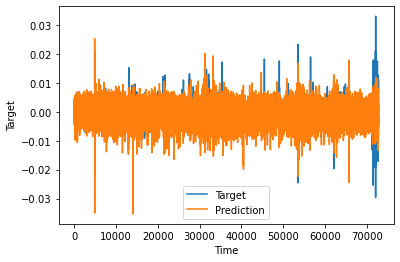

Bitcoin: 0.0000


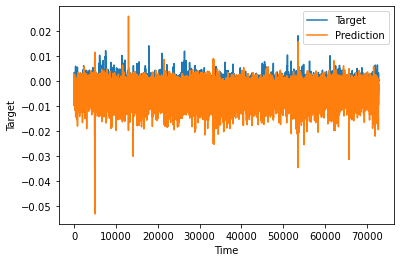

Dogecoin: -0.0045


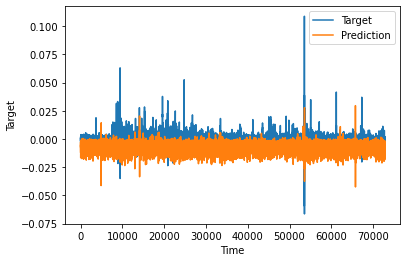

EOS.IO: -0.0052


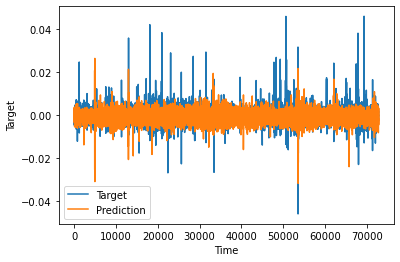

Ethereum Classic: 0.0067


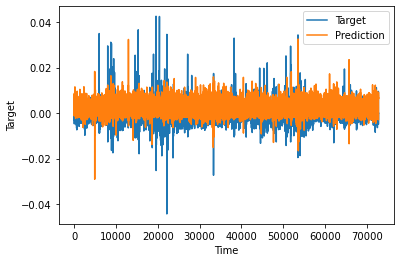

Ethereum: 0.0015


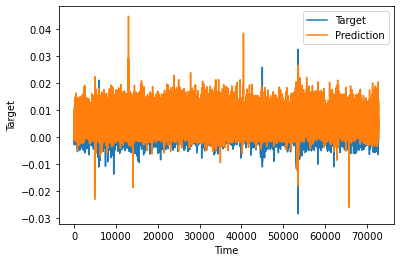

IOTA: -0.0076


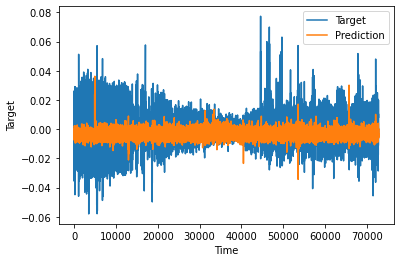

Litecoin: -0.0059


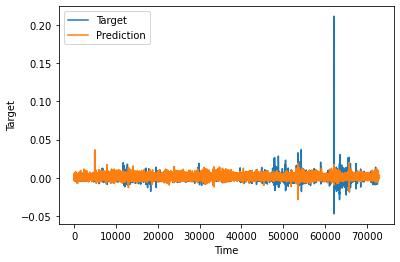

Maker: 0.0056


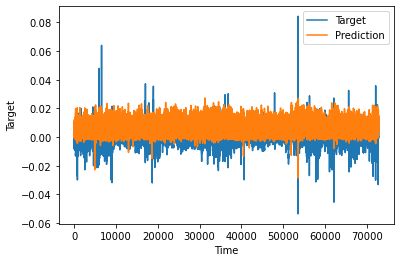

TRON: 0.0225


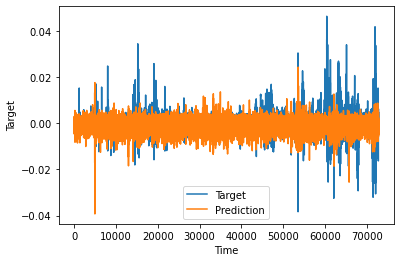

Stellar: 0.0169


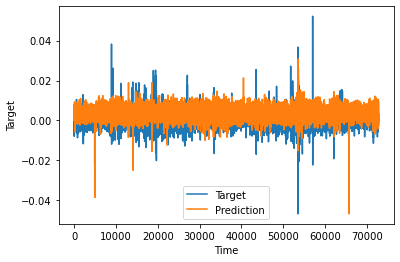

Monero: 0.0139


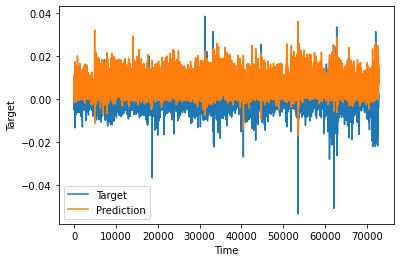

In [30]:
perf_df_2_layer = mlstm.prediction_details(predictions=predictions_Bidirectional_2_layer, y_test=y_test, asset_details=info, model_name ='LSTM_bidirectional_2_layers',assets=range(N_ASSETS))

In [31]:
perf_df_2_layer = perf_df_2_layer.append([pd.Series(['Bidirectional_2_layer', 'WEIGHTED', (perf_df_2_layer['corr']*perf_df_2_layer['weights']).sum(), 1 ],index = perf_df_2_layer.columns)], ignore_index=True)

perf_df_2_layer.to_csv('Performanceidirectional_2_layers_LSTM.csv')

perf_df_2_layer

Model             asset      corr   weights
0   LSTM_bidirectional_2_layers           Cardano -0.000025  4.304065
1   LSTM_bidirectional_2_layers      Bitcoin Cash -0.004515  6.779922
2   LSTM_bidirectional_2_layers      Binance Coin  0.011967  2.397895
3   LSTM_bidirectional_2_layers           Bitcoin  0.000028  4.406719
4   LSTM_bidirectional_2_layers          Dogecoin -0.004531  3.555348
5   LSTM_bidirectional_2_layers            EOS.IO -0.005217  1.386294
6   LSTM_bidirectional_2_layers  Ethereum Classic  0.006651  5.894403
7   LSTM_bidirectional_2_layers          Ethereum  0.001515  2.079442
8   LSTM_bidirectional_2_layers              IOTA -0.007567  1.098612
9   LSTM_bidirectional_2_layers          Litecoin -0.005940  2.397895
10  LSTM_bidirectional_2_layers             Maker  0.005586  1.098612
11  LSTM_bidirectional_2_layers              TRON  0.022503  1.609438
12  LSTM_bidirectional_2_layers           Stellar  0.016905  2.079442
13  LSTM_bidirectional_2_layers            Monero  0.013912  1.791759
14        Bidirectional_2_layer          WEIGHTED  0.096994  1.000000

2 LSTM

In [14]:
model_2lstm = mlstm.get_model_2lstm(X_train, y_train)

2022-01-07 10:11:28.446422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
641/641 [==============================] - 302s 355ms/step - loss: -0.0050 - Correlation: 0.0213 - val_loss: -0.0041 - val_Correlation: 0.0305

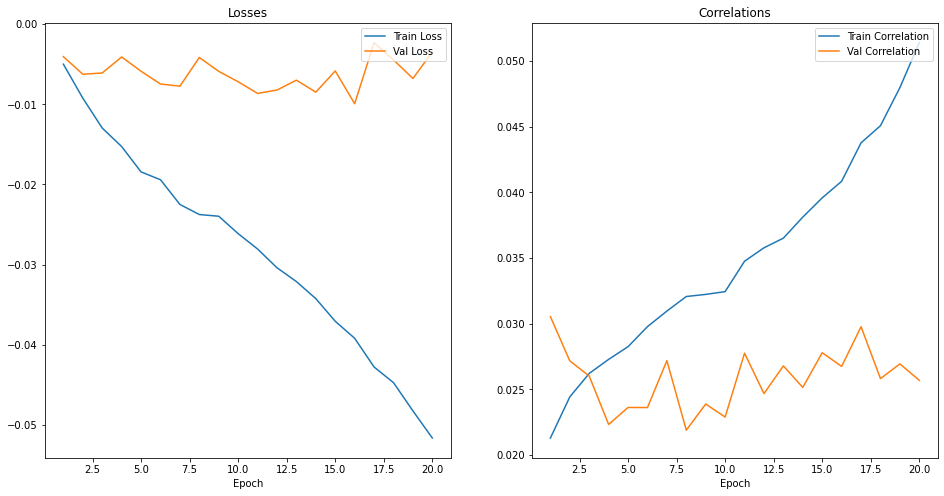

In [15]:
history_model_2lstm = model_2lstm.fit(train_generator, validation_data=(val_generator), epochs=20, callbacks=[lr])

mlstm.plot_training_history(history_model_2lstm)


In [16]:
predictions_model_2lstm = model_2lstm.predict(val_generator)

Asset:    Corr. coef.
---------------------
Cardano: 0.0270


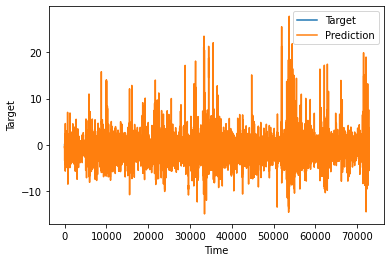

Bitcoin Cash: 0.0192


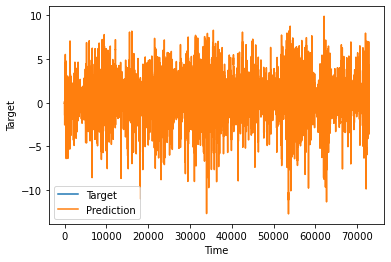

Binance Coin: 0.0272


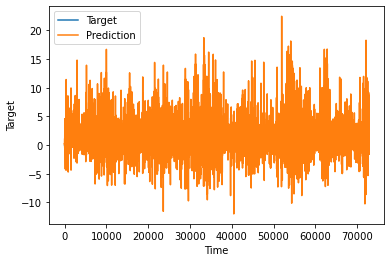

Bitcoin: 0.0142


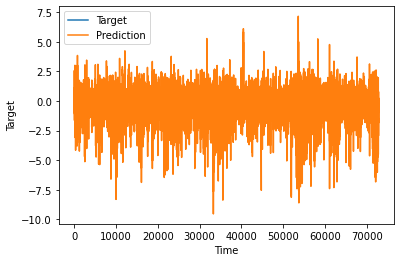

Dogecoin: -0.0193


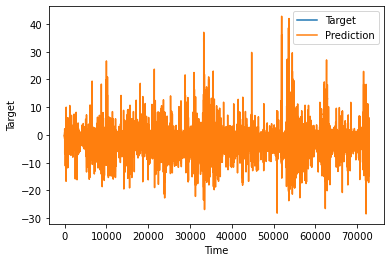

EOS.IO: -0.0144


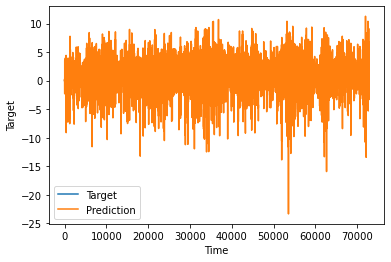

Ethereum Classic: 0.0022


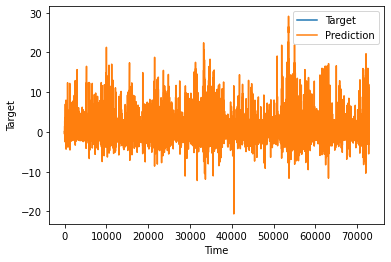

Ethereum: 0.0138


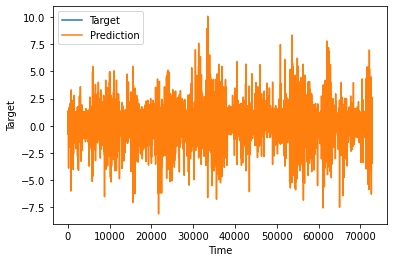

IOTA: -0.0182


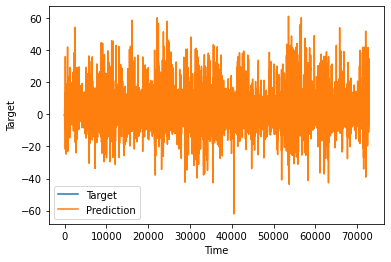

Litecoin: 0.0106


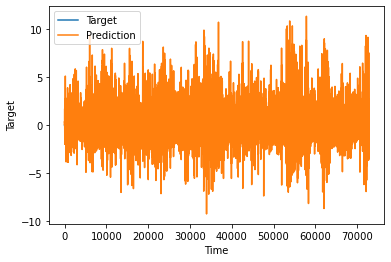

Maker: 0.0209


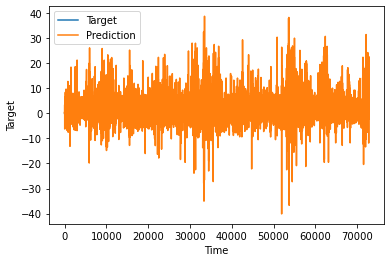

TRON: 0.0373


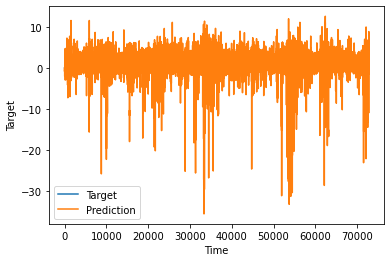

Stellar: 0.0118


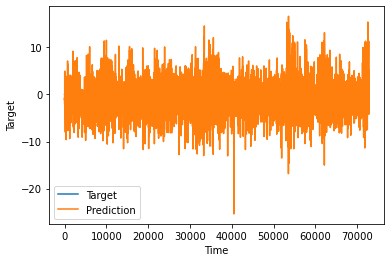

Monero: 0.0278


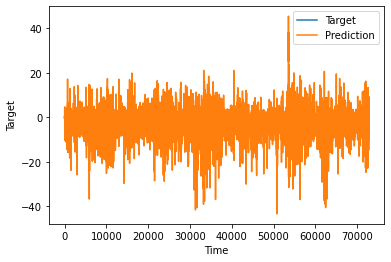

In [17]:
perf_df_model_2lstm = mlstm.prediction_details(predictions=predictions_model_2lstm,
                                           y_test=y_test, asset_details=info,model_name ='LSTM_2layer',assets=range(N_ASSETS))

In [18]:
perf_df_model_2lstm = perf_df_model_2lstm.append([pd.Series(['LSTM_2_layers', 'WEIGHTED', (perf_df_model_2lstm['corr']*perf_df_model_2lstm['weights']).sum(), 1 ],index = perf_df_model_2lstm.columns)], ignore_index=True)

perf_df_model_2lstm.to_csv('Performance_2_layers_LSTM.csv')

perf_df_model_2lstm

Model             asset      corr   weights
0     LSTM_2layer           Cardano  0.026952  4.304065
1     LSTM_2layer      Bitcoin Cash  0.019248  6.779922
2     LSTM_2layer      Binance Coin  0.027198  2.397895
3     LSTM_2layer           Bitcoin  0.014228  4.406719
4     LSTM_2layer          Dogecoin -0.019335  3.555348
5     LSTM_2layer            EOS.IO -0.014364  1.386294
6     LSTM_2layer  Ethereum Classic  0.002241  5.894403
7     LSTM_2layer          Ethereum  0.013795  2.079442
8     LSTM_2layer              IOTA -0.018169  1.098612
9     LSTM_2layer          Litecoin  0.010630  2.397895
10    LSTM_2layer             Maker  0.020914  1.098612
11    LSTM_2layer              TRON  0.037349  1.609438
12    LSTM_2layer           Stellar  0.011754  2.079442
13    LSTM_2layer            Monero  0.027761  1.791759
14  LSTM_2_layers          WEIGHTED  0.490463  1.000000

In [85]:
print(perf_df[-1:])
print(perf_df_2_layer[-1:])
print(perf_df_model_2lstm[-1:])

           Model     asset      corr  weights
14  1 layer LSTM  WEIGhTED  3.667704      1.0
                    Model     asset      corr  weights
14  Bidirectional_2_layer  WEIGHTED  2.082037      1.0
            Model     asset      corr  weights
14  LSTM_2_layers  WEIGHTED  2.532233      1.0
